Data contains 86532 cells and 29127 genes.


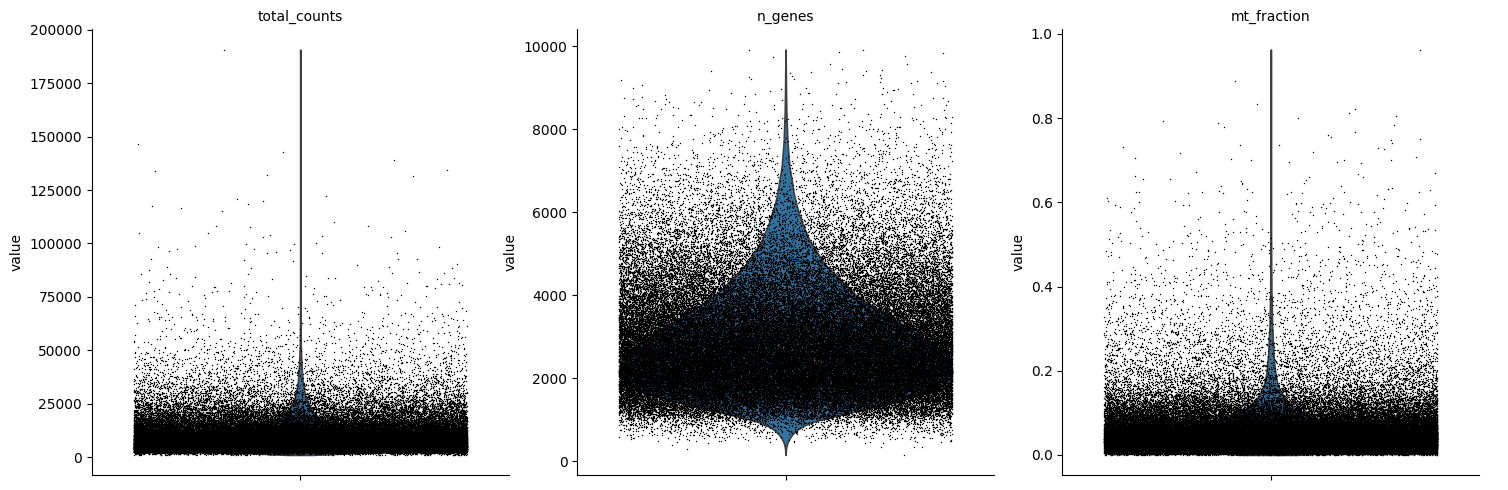

Filtered data contains 83384 cells and 29127 genes.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


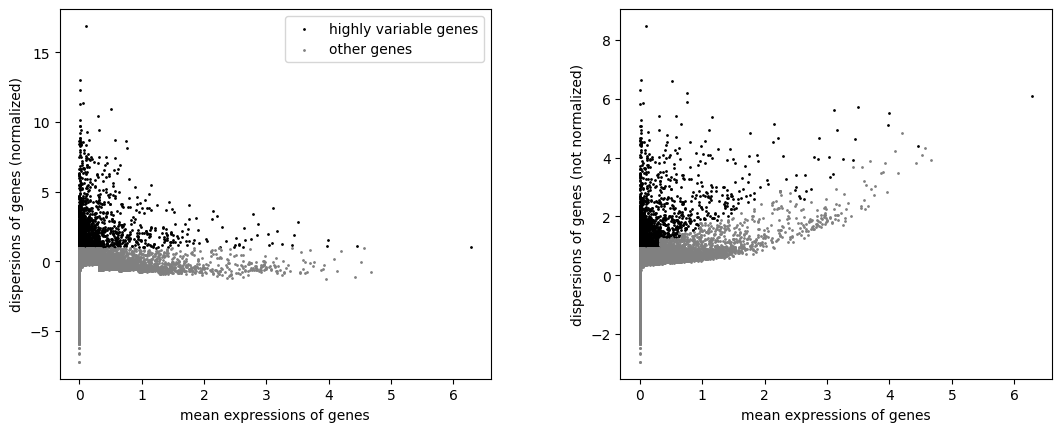

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


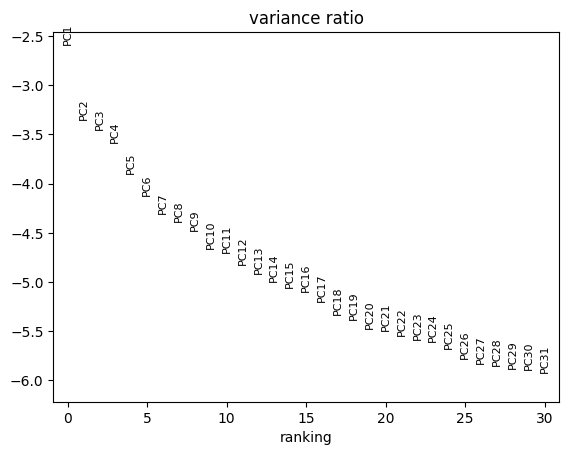

/var/folders/20/_1v77ht92tdbcwjslg02y9l40000gn/T/ipykernel_72236/4135108757.py:60: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)  # Perform clustering


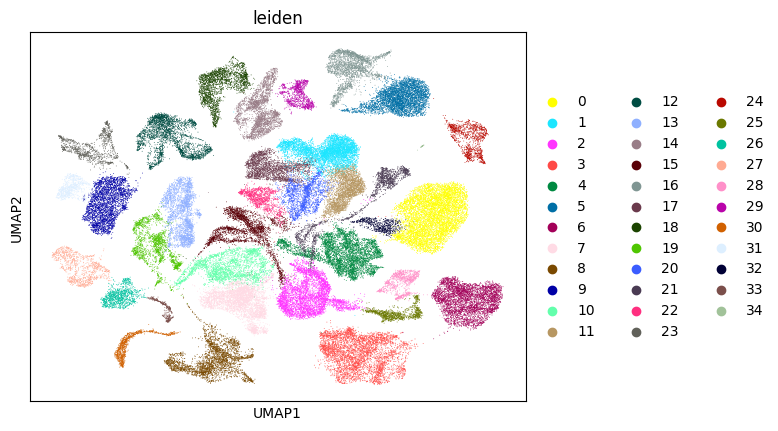

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/tools/_rank_genes

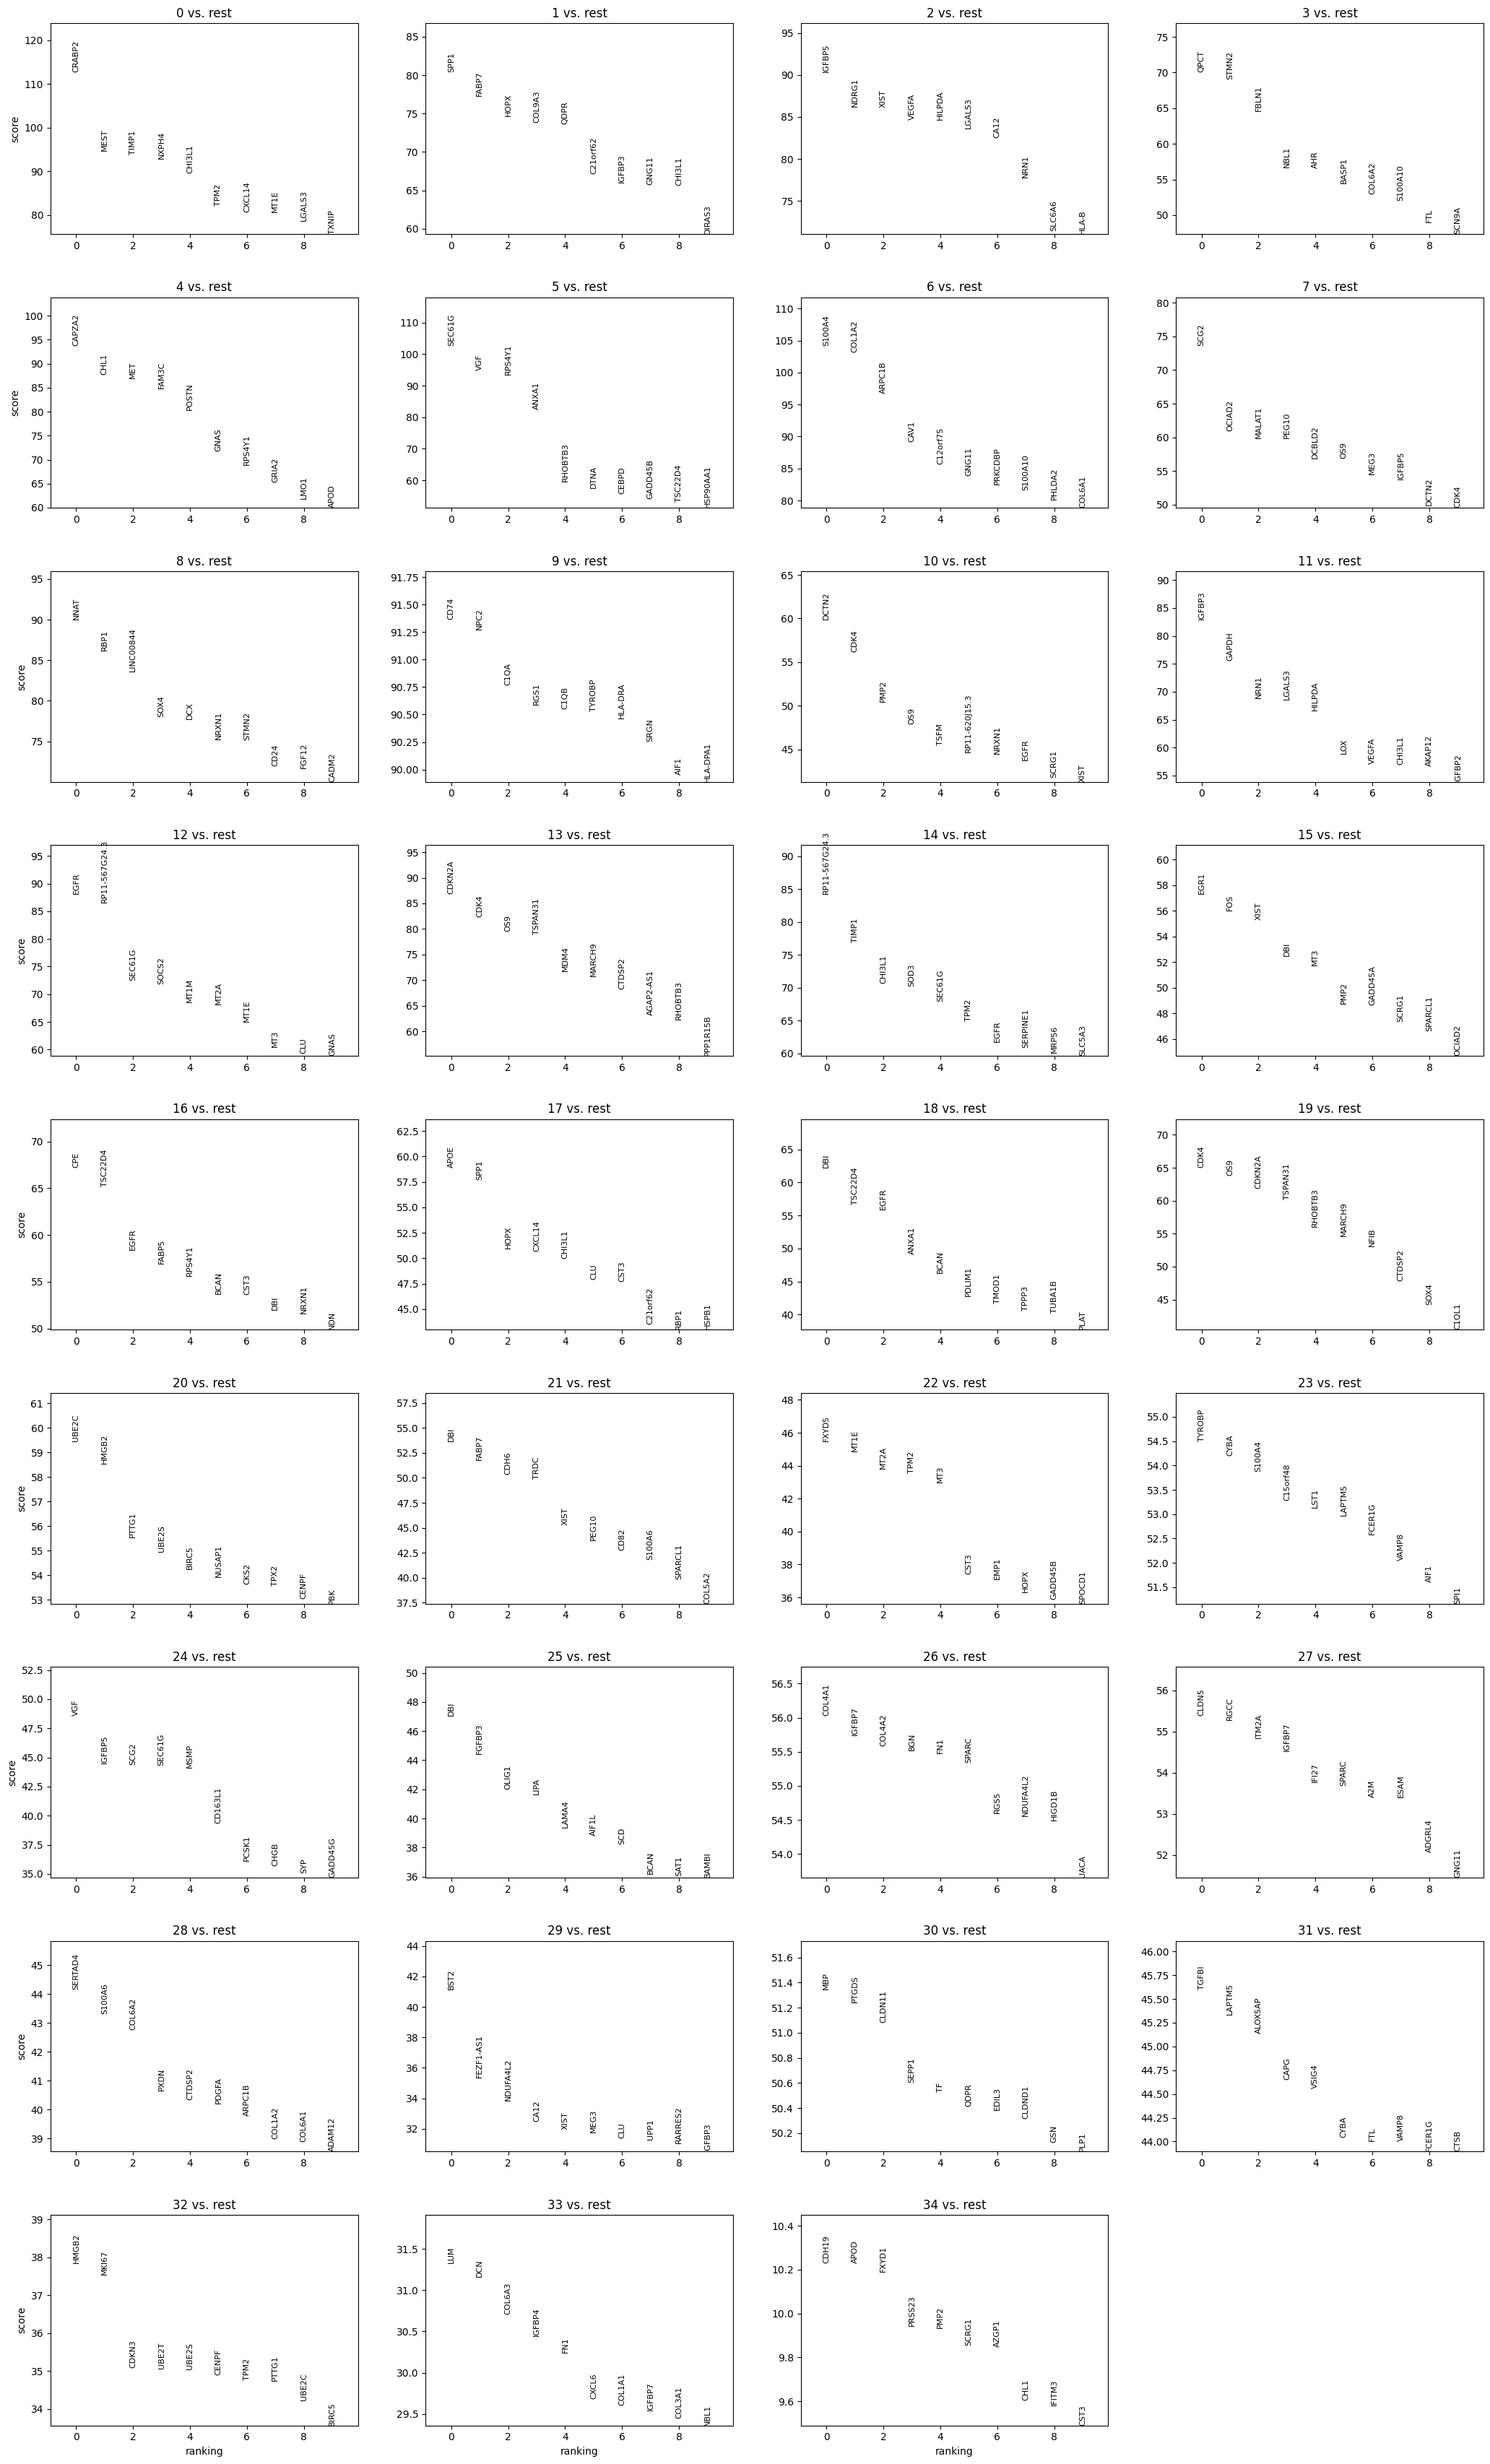

Top marker genes for each cluster:
        0         1       2        3       4         5         6       7  \
0  CRABP2      SPP1  IGFBP5     QPCT  CAPZA2    SEC61G    S100A4    SCG2   
1    MEST     FABP7   NDRG1    STMN2    CHL1       VGF    COL1A2  OCIAD2   
2   TIMP1      HOPX    XIST    FBLN1     MET    RPS4Y1    ARPC1B  MALAT1   
3   NXPH4    COL9A3   VEGFA     NBL1   FAM3C     ANXA1      CAV1   PEG10   
4  CHI3L1      QDPR  HILPDA      AHR   POSTN   RHOBTB3  C12orf75  DCBLD2   
5    TPM2  C21orf62  LGALS3    BASP1    GNAS      DTNA     GNG11     OS9   
6  CXCL14    IGFBP3    CA12   COL6A2  RPS4Y1     CEBPD   PRKCDBP    MEG3   
7    MT1E     GNG11    NRN1  S100A10   GRIA2   GADD45B   S100A10  IGFBP5   
8  LGALS3    CHI3L1  SLC6A6      FTL    LMO1   TSC22D4    PHLDA2   DCTN2   
9   TXNIP    DIRAS3   HLA-B    SCN9A    APOD  HSP90AA1    COL6A1    CDK4   

           8         9  ...      25        26      27       28         29  \
0       NNAT      CD74  ...     DBI    COL4A1   CLD

KeyError: 'Could not find key RPS27A in .var_names or .obs.columns.'

<Figure size 2183.4x480 with 0 Axes>

In [7]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Step 1: Loading Data
# Assume your dataset is in the 10x Genomics format (matrix.mtx, barcodes.tsv, features.tsv)
data_dir = "/Users/kirtana/Documents/project/" 
adata = sc.read_10x_mtx(data_dir, var_names="gene_symbols", cache=False)

print(f"Data contains {adata.shape[0]} cells and {adata.shape[1]} genes.")

# Step 2: Quality Control
# Adding QC metrics: total counts, number of genes expressed, and mitochondrial gene percentage
adata.obs["total_counts"] = adata.X.sum(axis=1).A1  # Total counts per cell
adata.obs["n_genes"] = (adata.X > 0).sum(axis=1).A1  # Number of genes expressed per cell

# Identifying mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.obs["mt_fraction"] = adata[:, adata.var["mt"]].X.sum(axis=1).A1 / adata.obs["total_counts"]

# Visualization of QC metrics
sc.pl.violin(
    adata,
    ["total_counts", "n_genes", "mt_fraction"],
    jitter=0.4,
    multi_panel=True
)
plt.show()

# Step 3: Filtering Low-Quality Cells
# Filtering cells with too few genes or too high mitochondrial gene content
sc.pp.filter_cells(adata, min_genes=200)
adata = adata[adata.obs["mt_fraction"] < 0.2]  # Removing cells with >20% mitochondrial reads

print(f"Filtered data contains {adata.shape[0]} cells and {adata.shape[1]} genes.")

# Step 4: Normalizing Data
sc.pp.normalize_total(adata, target_sum=1e4)  # Normalizing to 10,000 reads per cell
sc.pp.log1p(adata)  # Log-transforming the data

# Step 5: Identification of Highly Variable Genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)
plt.show()

# Retaining only highly variable genes
adata = adata[:, adata.var["highly_variable"]]

# Step 6: Scaling and Performing PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata, log=True)
plt.show()

# Step 7: Nearest Neighbors and Clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)  # Compute UMAP for visualization
sc.tl.leiden(adata, resolution=0.5)  # Perform clustering

# Visualization of UMAP with clusters
sc.pl.umap(adata, color=["leiden"])
plt.show()

# Step 8: Differential Gene Expression Analysis
# Finding marker genes for each cluster
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)
plt.show()

# Saving marker gene results
marker_genes = pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(10)
print("Top marker genes for each cluster:")
print(marker_genes)



# Step 10: Glioblastoma-Specific Analysis 
# Analyzing glioblastoma-related genes or pathways
glioblastoma_markers = ["EGFR", "PDGFRA", "CD44", "SOX2", "OLIG2"]  # Example markers
for gene in glioblastoma_markers:
    if gene in adata.var_names:
        sc.pl.umap(adata, color=gene, use_raw=False)
        plt.show()
    else:
        print(f"{gene} is not found in the dataset.")

# Step 11: Save Processed Data
adata.write_h5ad("/path/to/save/processed_data.h5ad")

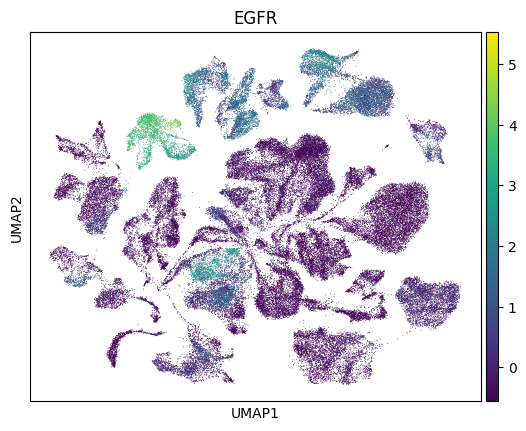

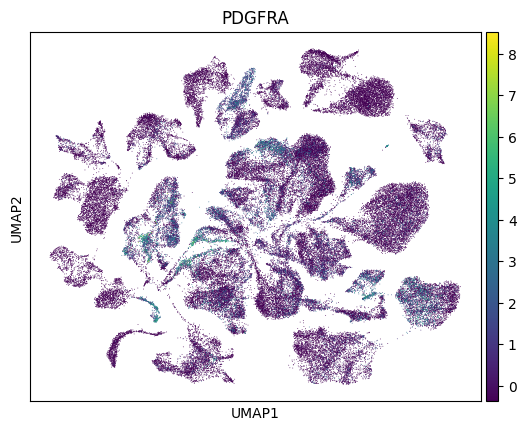

CD44 is not found in the dataset.
SOX2 is not found in the dataset.


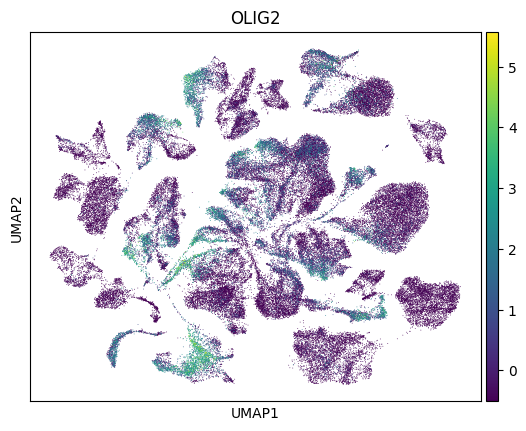

In [8]:
glioblastoma_markers = ["EGFR", "PDGFRA", "CD44", "SOX2", "OLIG2"]  # Example markers
for gene in glioblastoma_markers:
    if gene in adata.var_names:
        sc.pl.umap(adata, color=gene, use_raw=False)
        plt.show()
    else:
        print(f"{gene} is not found in the dataset.")